In [8]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

sns.set(style="whitegrid")

# ====== Config ======
CSV_PATH = "esol.csv"      # change path if needed
SMILES_COL = "smiles"
TARGET_COL = "measured log solubility in mols per litre"

RD_DESC_FUNCS = [
    Descriptors.MolWt, Descriptors.MolLogP, Descriptors.TPSA,
    Descriptors.NumHDonors, Descriptors.NumHAcceptors,
    rdMolDescriptors.CalcNumAliphaticRings, rdMolDescriptors.CalcNumAromaticRings,
    rdMolDescriptors.CalcNumRotatableBonds
]
RD_DESC_NAMES = ["MW","LogP","TPSA","HBD","HBA","AliRings","AroRings","RotB"]

def smiles_to_desc(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None: 
            return None
        return [fn(mol) for fn in RD_DESC_FUNCS]
    except Exception:
        return None

In [6]:
import pandas as pd
df = pd.read_csv('delaney-processed.csv')
print(df.columns)

Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles'],
      dtype='object')


In [7]:
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [10]:
#load and cleaning the data
df = pd.read_csv('delaney-processed.csv')
print("Initial rows:", len(df))
df = df.dropna(subset=[SMILES_COL, TARGET_COL]).reset_index(drop=True)
print("After dropping NA rows:", len(df))

Initial rows: 1128
After dropping NA rows: 1128


In [11]:
# removing invalid SMILES
desc_series = df[SMILES_COL].apply(smiles_to_desc)
valid_mask = desc_series.apply(lambda x: x is not None)
df = df.loc[valid_mask].reset_index(drop=True)
print("After dropping invalid SMILES:", len(df))

After dropping invalid SMILES: 1128


In [12]:
# createing descriptor DataFrame
X = pd.DataFrame(desc_series[valid_mask].tolist(), columns=RD_DESC_NAMES)
y = df[TARGET_COL].astype(float).values


Descriptor summary:


,count,mean,std,min,25%,50%,75%,max
MW,1128.0,203.937074,102.738077,16.0430,121.1830,182.179,270.3720,780.9490
LogP,1128.0,2.447520,1.852875,-7.5714,1.4149,2.339,3.4022,10.3886
TPSA,1128.0,34.872881,35.383593,0.0000,0.0000,26.300,55.4400,268.6800
HBD,1128.0,0.701241,1.089727,0.0000,0.0000,0.000,1.0000,11.0000
HBA,1128.0,2.111702,2.153375,0.0000,0.0000,2.000,3.0000,16.0000
AliRings,1128.0,0.460106,1.046482,0.0000,0.0000,0.000,0.0000,8.0000
AroRings,1128.0,0.930851,1.005136,0.0000,0.0000,1.000,2.0000,7.0000
RotB,1128.0,2.177305,2.640974,0.0000,0.0000,1.000,3.0000,23.0000


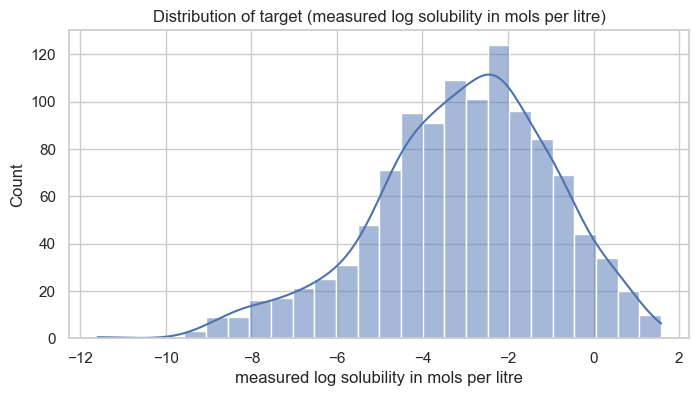

In [13]:
# Quick EDA 
print("\nDescriptor summary:")
display(X.describe().T)
plt.figure(figsize=(8,4))
sns.histplot(y, kde=True)
plt.title("Distribution of target (measured log solubility in mols per litre)")
plt.xlabel("measured log solubility in mols per litre")
plt.show()

In [14]:
#Train/test split ======
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.20, random_state=42)
print("\nTrain/test sizes:", Xtr.shape, Xte.shape)


Train/test sizes: (902, 8) (226, 8)


In [15]:
# Pipelines: Linear (baseline) and RandomForest
k_features = min(6, X.shape[1])  # keep top 6 descriptors (or fewer if not available)

lin_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("kbest", SelectKBest(score_func=f_regression, k=k_features)),
    ("model", LinearRegression())
])

rf_pipe = Pipeline([
    ("scaler", StandardScaler()),   # harmless for RF
    ("kbest", SelectKBest(score_func=f_regression, k=k_features)),
    ("model", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))
])

In [16]:
#Cross-validation (5-fold) - R^2 
cv = KFold(n_splits=5, shuffle=True, random_state=42)
print("\nCross-validation R² (5-fold):")
for name, pipe in [("Linear", lin_pipe), ("RandomForest", rf_pipe)]:
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="r2", n_jobs=-1)
    print(f"  {name}: mean R² = {scores.mean():.3f}  ± {scores.std():.3f}")



Cross-validation R² (5-fold):
  Linear: mean R² = 0.781  ± 0.015
  RandomForest: mean R² = 0.874  ± 0.016


In [17]:
# Fit on training, evaluate on test ======
print("\nTrain -> Test evaluation:")
for name, pipe in [("Linear", lin_pipe), ("RandomForest", rf_pipe)]:
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xte)
    print(f"  [{name}] MAE = {mean_absolute_error(yte, pred):.3f}   R² = {r2_score(yte, pred):.3f}")



Train -> Test evaluation:
  [Linear] MAE = 0.793   R² = 0.767
  [RandomForest] MAE = 0.583   R² = 0.853


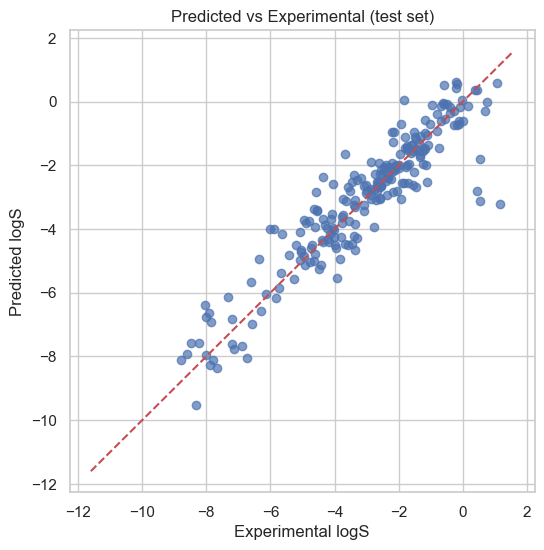

In [18]:
#Diagnostic plot for best model (choose RF if it has higher test R²)
best_model = rf_pipe if r2_score(yte, rf_pipe.predict(Xte)) >= r2_score(yte, lin_pipe.predict(Xte)) else lin_pipe
y_pred = best_model.predict(Xte)

plt.figure(figsize=(6,6))
plt.scatter(yte, y_pred, alpha=0.7)
mn, mx = min(y.min(), y_pred.min()), max(y.max(), y_pred.max())
plt.plot([mn,mx],[mn,mx], 'r--')
plt.xlabel("Experimental logS"); plt.ylabel("Predicted logS")
plt.title("Predicted vs Experimental (test set)")
plt.show()

In [19]:
#Feature importance via permutation (on RF pipeline after selection)
# Extract the selected feature names after SelectKBest
kbest = best_model.named_steps['kbest']
selected_idx = kbest.get_support(indices=True)
selected_features = [X.columns[i] for i in selected_idx]
print("\nSelected features:", selected_features)


Selected features: ['MW', 'LogP', 'HBD', 'AliRings', 'AroRings', 'RotB']



Permutation importances (test set):


,feature,importance,std
1,LogP,1.505796,0.104852
0,MW,0.181871,0.025801
4,AroRings,0.013715,0.003557
2,HBD,0.008272,0.003266
5,RotB,0.004940,0.001917
3,AliRings,0.001041,0.001676


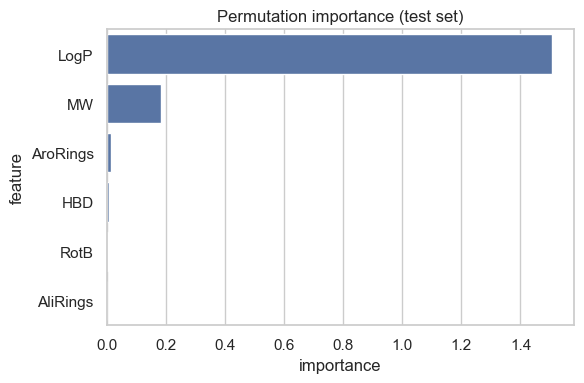

In [20]:
# get trained RF estimator 
rf_est = best_model.named_steps['model']
# Permutation importance on test set (using scaled inputs because pipeline includes scaler)
Xte_sel = best_model.named_steps['kbest'].transform(best_model.named_steps['scaler'].transform(Xte))
res = permutation_importance(rf_est, Xte_sel, yte, n_repeats=20, random_state=42, n_jobs=-1)
imp_means = res.importances_mean
imp_std = res.importances_std
imp_df = pd.DataFrame({"feature": selected_features, "importance": imp_means, "std": imp_std}).sort_values("importance", ascending=False)
print("\nPermutation importances (test set):")
display(imp_df)

plt.figure(figsize=(6,4))
sns.barplot(data=imp_df, x="importance", y="feature")
plt.title("Permutation importance (test set)")
plt.tight_layout()
plt.show()

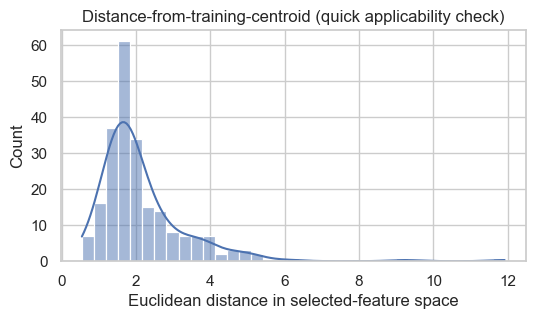

In [23]:

# Mahalanobis-like simple check: distance from training centroid in selected-feature space
from scipy.spatial.distance import cdist
scaler_for_ad = best_model.named_steps['scaler']
Xtr_sel = best_model.named_steps['kbest'].transform(scaler_for_ad.transform(Xtr))
Xte_sel = best_model.named_steps['kbest'].transform(scaler_for_ad.transform(Xte))
centroid = Xtr_sel.mean(axis=0)
dists = cdist(Xte_sel, centroid.reshape(1,-1)).ravel()
plt.figure(figsize=(6,3))
sns.histplot(dists, kde=True)
plt.title("Distance-from-training-centroid (quick applicability check)")
plt.xlabel("Euclidean distance in selected-feature space")
plt.show()

print()


In [25]:
# computing descriptors & fingerprints
desc_series = df[SMILES_COL].apply(smiles_to_desc)
valid_mask = desc_series.apply(lambda x: x is not None)
df = df.loc[valid_mask].reset_index(drop=True)
X_desc = pd.DataFrame(desc_series[valid_mask].tolist(), columns=RD_DESC_NAMES)
y = df.loc[valid_mask, TARGET_COL].astype(float).values

In [29]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np

def smiles_to_morgan(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(nBits, dtype=int)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


In [30]:
nBits = 1024   # you can lower to 512 if it’s slow
X_fp = np.vstack(df[SMILES_COL].apply(lambda s: smiles_to_morgan(s, radius=2, nBits=nBits)).values)
print("Fingerprint matrix shape:", X_fp.shape)


[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerator
[15:22:06] DEPRECATION WARNING: please use MorganGenerat

Fingerprint matrix shape: (1128, 1024)


In [32]:
# ===== train/test split (same random state for fair comparison) =====
Xtr_desc, Xte_desc, ytr, yte = train_test_split(X_desc, y, test_size=0.20, random_state=42)
# split fingerprints with same indices: easiest is to use the same indices
from sklearn.model_selection import train_test_split
_, _, Xtr_fp, Xte_fp = train_test_split(df.index.values, df.index.values, test_size=0.20, random_state=42)
# index-based split:
train_idx = np.setdiff1d(df.index.values, Xte_fp)
test_idx  = Xte_fp
Xtr_fp = X_fp[train_idx]
Xte_fp = X_fp[test_idx]
# fix ytr/yte to ensure they align (already done above via y split) - but recompute to be safe:
ytr = y[train_idx]
yte = y[test_idx]

# ===== Pipelines =====
k_features = min(6, X_desc.shape[1])


In [33]:
X_fp.shape


(1128, 1024)

In [34]:
# (A) Descriptor pipeline using SelectKBest (baseline)
desc_select_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("kbest", SelectKBest(score_func=f_regression, k=k_features)),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])


In [36]:
# (B) Descriptor pipeline using RFE (Recursive Feature Elimination)
# RFE will wrap a RandomForestRegressor and select top k_features descriptors
from sklearn.feature_selection import RFE
rfe_estimator = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rfe_selector = RFE(estimator=rfe_estimator, n_features_to_select=k_features, step=1, verbose=0)
# We'll build a pipeline where RFE runs AFTER scaling (RFE uses the raw features; scaling isn't strictly needed for RF but kept for similarity)
desc_rfe_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rfe", rfe_selector),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

In [37]:
# (C) Fingerprint pipeline (no scaling necessary for bit vectors, but we'll leave a passthrough)
fp_pipe = Pipeline([
    # no scaler for bit vectors
    ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

In [38]:
# Cross-validation comparison (R^2) 
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nCross-validation R² (5-fold) comparing pipelines:")
for name, pipe, Xdata in [
    ("Desc_SelectKBest", desc_select_pipe, X_desc.values),
    ("Desc_RFE",        desc_rfe_pipe,        X_desc.values),
    ("Morgan_FP",       fp_pipe,             X_fp)
]:
    scores = cross_val_score(pipe, Xdata, y, cv=cv, scoring="r2", n_jobs=-1)
    print(f"  {name}: mean R² = {scores.mean():.3f} ± {scores.std():.3f}")



Cross-validation R² (5-fold) comparing pipelines:
  Desc_SelectKBest: mean R² = 0.874 ± 0.016
  Desc_RFE: mean R² = 0.884 ± 0.016
  Morgan_FP: mean R² = 0.665 ± 0.022


In [39]:
# Fit on training, evaluate on test
print("\nTrain -> Test evaluation (MAE, R²):")
pipelines_to_test = [
    ("Desc_SelectKBest", desc_select_pipe, Xtr_desc.values, Xte_desc.values),
    ("Desc_RFE",         desc_rfe_pipe,        Xtr_desc.values, Xte_desc.values),
    ("Morgan_FP",        fp_pipe,             Xtr_fp,          Xte_fp)
]
for name, pipe, Xtr_, Xte_ in pipelines_to_test:
    pipe.fit(Xtr_, ytr)
    pred = pipe.predict(Xte_)
    print(f"  [{name}] MAE = {mean_absolute_error(yte, pred):.3f}   R² = {r2_score(yte, pred):.3f}")



Train -> Test evaluation (MAE, R²):
  [Desc_SelectKBest] MAE = 1.973   R² = -0.317
  [Desc_RFE] MAE = 1.930   R² = -0.278
  [Morgan_FP] MAE = 0.890   R² = 0.704


In [40]:
# Show selected features from RFE (descriptor names) 
rfe_step = desc_rfe_pipe.named_steps['rfe']
selected_idx = np.where(rfe_step.support_)[0]   # boolean mask -> indices
selected_features = [X_desc.columns[i] for i in selected_idx]
print("\nRFE selected features (top {}): {}".format(len(selected_features), selected_features))



RFE selected features (top 6): ['MW', 'LogP', 'TPSA', 'HBA', 'AroRings', 'RotB']


In [41]:
# Permutation importance for RFE model (on test set)
rf_est = desc_rfe_pipe.named_steps['model']
# transform test descriptors through scaler + rfe selector to get selected-feature matrix
Xte_sel = desc_rfe_pipe.named_steps['rfe'].transform(desc_rfe_pipe.named_steps['scaler'].transform(Xte_desc.values))
res = permutation_importance(rf_est, Xte_sel, yte, n_repeats=20, random_state=42, n_jobs=-1)
imp_means = res.importances_mean
imp_std = res.importances_std
imp_df = pd.DataFrame({"feature": selected_features, "importance": imp_means, "std": imp_std}).sort_values("importance", ascending=False)
print("\nPermutation importances (RFE-selected features):")
display(imp_df)


Permutation importances (RFE-selected features):


,feature,importance,std
1,LogP,-0.042317,0.028860
5,RotB,-0.053119,0.013761
3,HBA,-0.070537,0.011453
2,TPSA,-0.119732,0.021812
4,AroRings,-0.190556,0.024416
0,MW,-0.248980,0.030694


In [44]:
# GridSearchCV for RF hyperparameters (on descriptor-RFE pipeline)
from sklearn.model_selection import GridSearchCV
print("\nRunning GridSearchCV for RandomForest (this may take a while)...")
param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 6, 12],
    "model__min_samples_leaf": [1, 3, 5]
}
gs = GridSearchCV(desc_rfe_pipe, param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=1)
gs.fit(Xtr_desc.values, ytr)
print("Best params:", gs.best_params_)
print("Best CV R² (grid):", gs.best_score_)


Running GridSearchCV for RandomForest (this may take a while)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'model__max_depth': 6, 'model__min_samples_leaf': 1, 'model__n_estimators': 200}
Best CV R² (grid): -0.04515118199650201


GridSearch best -> Test MAE: 1.780967841714952  R²: -0.0457305307803324


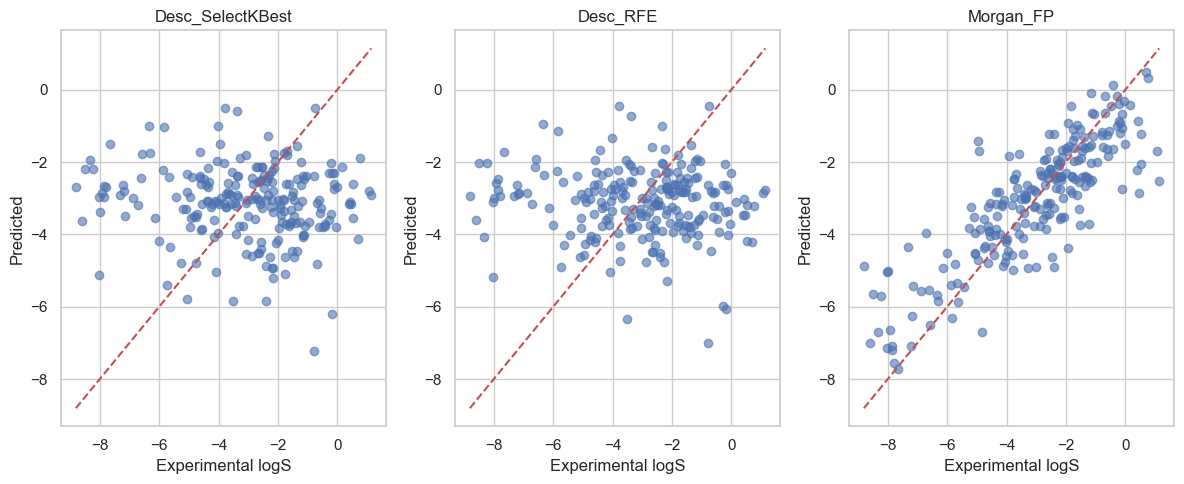

In [45]:
#  Evaluate best grid model on test ======
best_grid = gs.best_estimator_
pred = best_grid.predict(Xte_desc.values)
print("GridSearch best -> Test MAE:", mean_absolute_error(yte, pred), " R²:", r2_score(yte, pred))

# Quick plots (compare predicted vs actual for RFE pipeline & fingerprint pipeline) =====
plt.figure(figsize=(12,5))
for i, (name, pipe, Xtr_, Xte_) in enumerate(pipelines_to_test):
    plt.subplot(1,3,i+1)
    ypred = pipe.predict(Xte_)
    plt.scatter(yte, ypred, alpha=0.6)
    mn, mx = min(yte.min(), ypred.min()), max(yte.max(), ypred.max())
    plt.plot([mn,mx],[mn,mx],'r--')
    plt.title(name)
    plt.xlabel("Experimental logS"); plt.ylabel("Predicted")
plt.tight_layout(); plt.show()